# CSCA-5632: Project Final
## Airline Flight Search Ranker
### Project Description
The focus of this project is to build machine learning models that can rank and predict which flight options a traveler will choose when presented with the flight search results. This is a group-wise ranking problem in that the target of the model is to rank the search results within each unique search session for each traveler.

The dataset is provided through a Kaggle competition, hosted by the Aeroclub IT ([FlightRank 2025: Aeroclub RecSysCup](#acknowledgements)). The data is provided as a parquet file containing approximately 18 million rows of flight search results for ~33 thousand travelers over a seven month period. Given the size of the dataset, the project will be broken into multiple steps, each with a specific focus.

The goal is to build a machine learning model, based on the historical data, that can rank the results of a flight search and predict based on the ranking of the search results. The model will be evaluated on a holdout set of data, and the final model will be used to rank the flight search results for the test set.

The approach for this project is to perform the final predictions by breaking the problem into two parts:

1. **Traveler Clustering**: For the first part, we will use unsupervised learning to cluster the travelers into groups based on profile, search, and behavioral features.
2. **Flight Ranker**: For the second part, we will use a ranking model to predict the rank of the flight search results for each traveler search session, with a separate model trained for each traveler segment.

The results will be evaluated using the HitRate@3 metric to compare the selected flight to the top 3 ranking search results for each search session.

$HitRate@3 = \frac{1}{|Q|} \sum_{i=1}^{|Q|} 1(rank_i \leq 3)$

Where:
* $|Q|$ is the number of searches within a search session
* $rank_i$ is the rank of the $i^{th}$ search
* $1(rank_i \leq 3)$ is 1 if the correct flight is in the top-3, 0 otherwise

### Project Setup
Instructions for setting up the project can be found in [**README.md**](./README.md)


### Project Summary
A summary of the project and steps can be found in [**README.md**](./README.md)

## Table of Contents

- [Imports](#imports)
- [Data Source](#data-source)
- [Exploratory Data Analysis](#exploratory-data-analysis)
- [Traveler Segmentation](#traveler-segmentation)
    - [Feature Engineering](#feature-engineering)
    - [Models](#models)
    - [Model Selection](#model-selection)
- [Flight Ranking](#flight-ranking)
    - [Feature Engineering](#feature-engineering-1)
    - [Models](#models-1)
    - [Model Selection](#model-selection-1)
- [Final Results](#final-results)
- [Next Steps](#next-steps)
- [License](#license)
- [Acknowledgements](#acknowledgements)

### Imports
Import the libraries and functions needed for the project

In [1]:
import gc
import joblib
import numpy as np
import polars as pl
import polars.selectors as cs

import matplotlib.pyplot as plt
import seaborn as sns

# project functions
from src.utils import stratified_flight_count_split

%load_ext autoreload
%autoreload 2

### Dataset Source
The dataset used for this project was provided by the [FlightRank 2025: Aeroclub RecSysCup](#acknowledgements) competition on [Kaggle](https://www.kaggle.com). The dataset files are too large to maintain within the [GitHut](https://github.com/jfroggatt/aeroclub_recsys_2025) project respository, so the competition project archive is downloaded to the local working directory, '/kaggle/input/aeroclub-recsys-2025/', and the `train.parquet` file is extracted. No other files are needed from the competition project archive.

In [2]:
# load train data file
train_df = pl.read_parquet('/kaggle/input/aeroclub-recsys-2025/train.parquet')

### Exploratory Data Analysis

In this section, we will explore the flight search data set from the `train.parquet` project file.

First, let's look at the shape, examine the first 100 rows of the data.

In [3]:
print(f'train data shape: {train_df.shape}')
train_df.head()

train data shape: (18145372, 127)


Id,bySelf,companyID,corporateTariffCode,frequentFlyer,nationality,isAccess3D,isVip,legs0_arrivalAt,legs0_departureAt,legs0_duration,legs0_segments0_aircraft_code,legs0_segments0_arrivalTo_airport_city_iata,legs0_segments0_arrivalTo_airport_iata,legs0_segments0_baggageAllowance_quantity,legs0_segments0_baggageAllowance_weightMeasurementType,legs0_segments0_cabinClass,legs0_segments0_departureFrom_airport_iata,legs0_segments0_duration,legs0_segments0_flightNumber,legs0_segments0_marketingCarrier_code,legs0_segments0_operatingCarrier_code,legs0_segments0_seatsAvailable,legs0_segments1_aircraft_code,legs0_segments1_arrivalTo_airport_city_iata,legs0_segments1_arrivalTo_airport_iata,legs0_segments1_baggageAllowance_quantity,legs0_segments1_baggageAllowance_weightMeasurementType,legs0_segments1_cabinClass,legs0_segments1_departureFrom_airport_iata,legs0_segments1_duration,legs0_segments1_flightNumber,legs0_segments1_marketingCarrier_code,legs0_segments1_operatingCarrier_code,legs0_segments1_seatsAvailable,legs0_segments2_aircraft_code,legs0_segments2_arrivalTo_airport_city_iata,…,legs1_segments2_baggageAllowance_weightMeasurementType,legs1_segments2_cabinClass,legs1_segments2_departureFrom_airport_iata,legs1_segments2_duration,legs1_segments2_flightNumber,legs1_segments2_marketingCarrier_code,legs1_segments2_operatingCarrier_code,legs1_segments2_seatsAvailable,legs1_segments3_aircraft_code,legs1_segments3_arrivalTo_airport_city_iata,legs1_segments3_arrivalTo_airport_iata,legs1_segments3_baggageAllowance_quantity,legs1_segments3_baggageAllowance_weightMeasurementType,legs1_segments3_cabinClass,legs1_segments3_departureFrom_airport_iata,legs1_segments3_duration,legs1_segments3_flightNumber,legs1_segments3_marketingCarrier_code,legs1_segments3_operatingCarrier_code,legs1_segments3_seatsAvailable,miniRules0_monetaryAmount,miniRules0_percentage,miniRules0_statusInfos,miniRules1_monetaryAmount,miniRules1_percentage,miniRules1_statusInfos,pricingInfo_isAccessTP,pricingInfo_passengerCount,profileId,ranker_id,requestDate,searchRoute,sex,taxes,totalPrice,selected,__index_level_0__
i64,bool,i64,i64,str,i64,bool,bool,str,str,str,str,str,str,f64,f64,f64,str,str,str,str,str,f64,str,str,str,f64,f64,f64,str,str,str,str,str,f64,str,str,…,f64,f64,str,str,str,str,str,f64,str,str,str,f64,f64,f64,str,str,str,str,str,f64,f64,f64,f64,f64,f64,f64,f64,i64,i64,str,datetime[ns],str,bool,f64,f64,i64,i64
0,true,57323,null,"""S7/SU/UT""",36,false,false,"""2024-06-15T16:20:00""","""2024-06-15T15:40:00""","""02:40:00""","""YK2""","""KJA""","""KJA""",1.0,0.0,1.0,"""TLK""","""02:40:00""","""216""","""KV""","""KV""",9.0,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,1.0,1,2087645,"""98ce0dabf6964640b63079fbafd42c…",2024-05-17 03:03:08,"""TLKKJA/KJATLK""",true,370.0,16884.0,1,0
1,true,57323,123,"""S7/SU/UT""",36,true,false,"""2024-06-15T14:50:00""","""2024-06-15T09:25:00""","""07:25:00""","""E70""","""OVB""","""OVB""",1.0,0.0,1.0,"""TLK""","""02:50:00""","""5358""","""S7""","""S7""",4.0,"""E70""","""KJA""","""KJA""",1.0,0.0,1.0,"""OVB""","""01:20:00""","""5311""","""S7""","""S7""",4.0,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,2300.0,null,1.0,3500.0,null,1.0,1.0,1,2087645,"""98ce0dabf6964640b63079fbafd42c…",2024-05-17 03:03:08,"""TLKKJA/KJATLK""",true,2240.0,51125.0,0,1
2,true,57323,null,"""S7/SU/UT""",36,false,false,"""2024-06-15T14:50:00""","""2024-06-15T09:25:00""","""07:25:00""","""E70""","""OVB""","""OVB""",1.0,0.0,1.0,"""TLK""","""02:50:00""","""5358""","""S7""","""S7""",4.0,"""E70""","""KJA""","""KJA""",1.0,0.0,1.0,"""OVB""","""01:20:00""","""5311""","""S7""","""S7""",4.0,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,2300.0,null,1.0,3500.0,null,1.0,1.0,1,2087645,"""98ce0dabf696

Let's look at the number of flight search responses, unique searches, and travelers

In [4]:
print(f'Number of flights: {len(train_df)}')
print(f'Number of unique searches: {train_df["ranker_id"].unique().count()}')
print(f'Number of unique travelers: {train_df["profileId"].unique().count()}')

Number of flights: 18145372
Number of unique searches: 105539
Number of unique travelers: 32922


Let's look at the distribution of the count of flight search results by unique search session

In [5]:
# Distribution of the flight counts per search
flight_counts = train_df.group_by('ranker_id').len().sort(by='len', descending=True)

flight_counts.head(100)

ranker_id,len
str,u32
"""f9833fe7d58441c8a8feed74fec32a…",8236
"""796854b386874b40b4a8843f70a2b0…",7841
"""4d0bee7eede2454187405709ea1877…",7793
"""db85d3d24c164a798b518be8fbce1f…",7678
"""92e54e4a04f94eec9c30a59cb729ed…",7676
…,…
"""cc4bb1a67186494d8e9e896650ca09…",5900
"""8c9acffad7244c8d8538ceaf1ac8d9…",5896
"""60b3b8945eec402bb56a8ebdbd1b1e…",5895


In [6]:
flight_counts.tail(100)

ranker_id,len
str,u32
"""96e27c0d59fa46a2960f1d0863f49a…",1
"""be8bfe2b14db4fc9b217114e2d768a…",1
"""52582309a1b44cfa897e4cc961026f…",1
"""8cb8e6d902644ee6a12aa91af1e3ca…",1
"""145b35caecef4845ad19a8a7669586…",1
…,…
"""118a0ac83a904ae9b5ed7b28631267…",1
"""5bfad885a3224b9581833d5b1c13a8…",1
"""3c2414750ce64fb7b8376162800885…",1


In [7]:
# Check statistics of the flight counts per search
flight_counts['len'].describe()

statistic,value
str,f64
"""count""",105539.0
"""null_count""",0.0
"""mean""",171.93049
"""std""",445.940118
"""min""",1.0
"""25%""",19.0
"""50%""",50.0
"""75%""",154.0
"""max""",8236.0


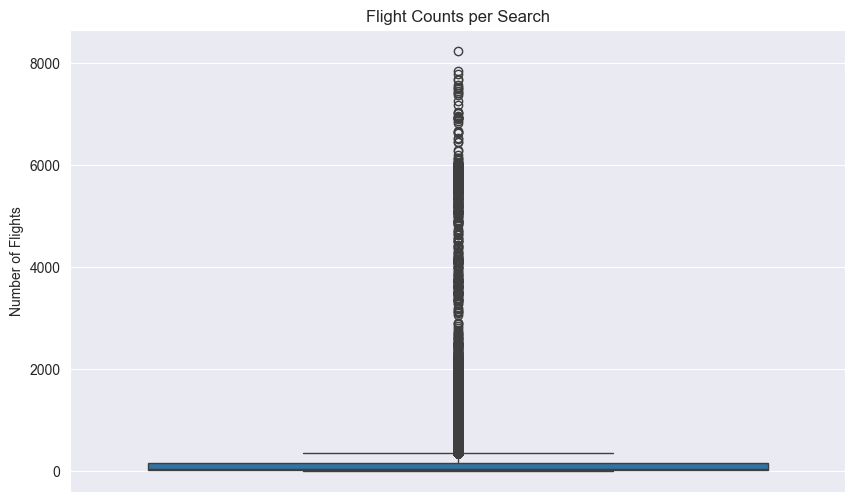

In [8]:
# Plot the distribution of the flight counts per search
plt.figure(figsize=(10, 6))
sns.boxplot(flight_counts['len'])
plt.title('Flight Counts per Search')
plt.ylabel('Number of Flights')
plt.show()

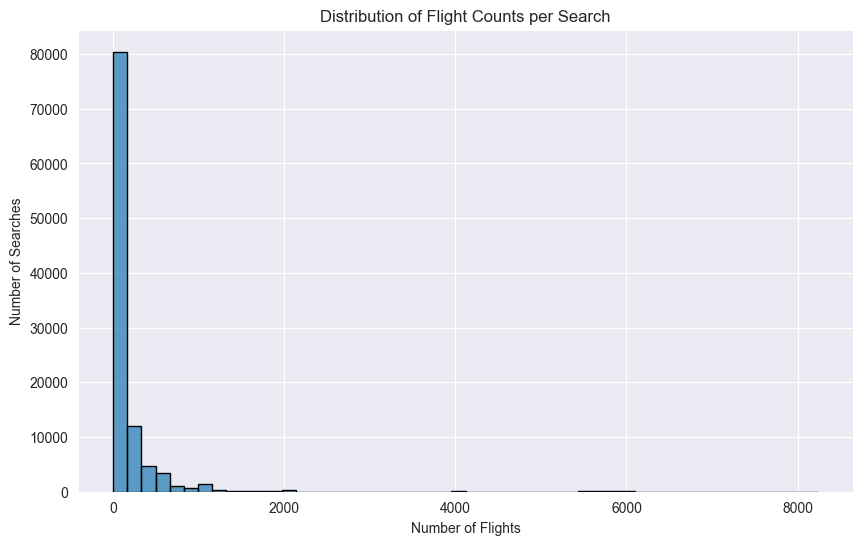

In [9]:
plt.figure(figsize=(10, 6))
sns.histplot(flight_counts['len'], bins=50, edgecolor='black', alpha=0.7)
plt.title('Distribution of Flight Counts per Search')
plt.xlabel('Number of Flights')
plt.ylabel('Number of Searches')
plt.show()

While the number of flight search results per session is generally less than 150 (3rd Quartile), there are significantly large outliers that we will likely need to address.

Let's look at the distribution of searches per unique traveler

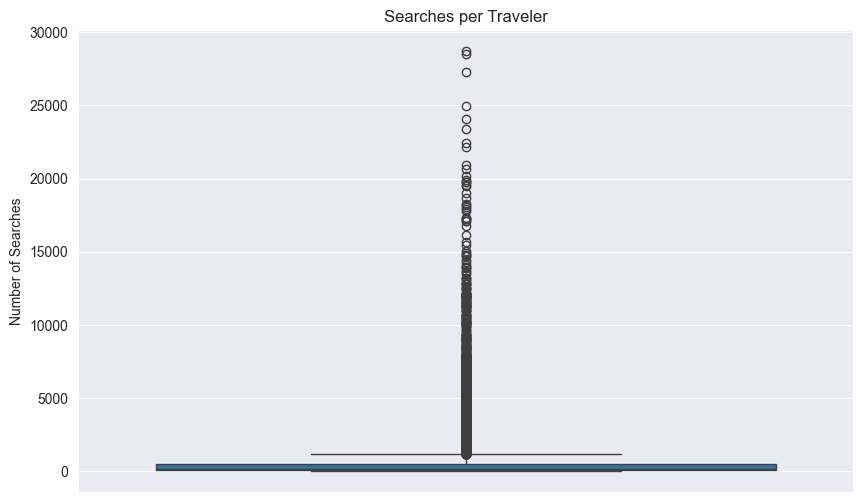

In [10]:
# Plot the distribution of searches per customer
cust_searches = train_df.group_by('profileId').len().sort(by='len', descending=True)
plt.figure(figsize=(10, 6))
sns.boxplot(cust_searches['len'])
plt.title('Searches per Traveler')
plt.ylabel('Number of Searches')
plt.show()

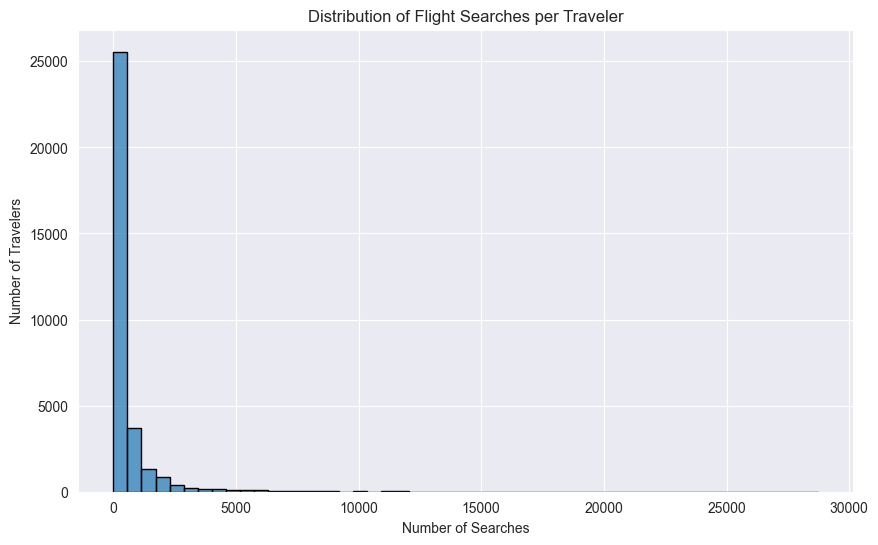

In [11]:
plt.figure(figsize=(10, 6))
sns.histplot(cust_searches['len'], bins=50, edgecolor='black', alpha=0.7)
plt.title('Distribution of Flight Searches per Traveler')
plt.xlabel('Number of Searches')
plt.ylabel('Number of Travelers')
plt.show()

In [12]:
cust_searches['len'].describe()

statistic,value
str,f64
"""count""",32922.0
"""null_count""",0.0
"""mean""",551.162505
"""std""",1290.835383
"""min""",1.0
"""25%""",53.0
"""50%""",168.0
"""75%""",505.0
"""max""",28718.0


While the majority of travelers generally have less than ~500 searches (3rd Quartile) there are definitely outliers here.

Now let's check the data types and attributes with NULL/Empty values.

In [13]:
# Check data types
pl.DataFrame({'data_type': [str(dtype) for dtype in train_df.schema.values()]}).group_by('data_type').len().sort('len', descending=True)

data_type,len
str,u32
"""String""",73
"""Float64""",41
"""Int64""",8
"""Boolean""",4
"""Datetime(time_unit='ns', time_…",1


In [14]:
# Determine the number and percentage of NULL/Empty values for each feature
results = []
for col in train_df.columns:
    # Get null count
    null_count = train_df.select(pl.col(col).is_null().sum()).item()
    # Get empty string count
    if train_df.schema[col] == pl.String:
        empty_count = train_df.select((pl.col(col) == "").sum()).item()
        missing_count = train_df.select((pl.col(col).is_null() | (pl.col(col) == "")).sum()).item()
    else:
        empty_count = 0
        missing_count = null_count

    results.append({
        'column': col,
        'data_type': str(train_df.schema[col]),
        'null_count': null_count,
        'empty_count': empty_count,
        'missing_count': missing_count,
        'missing_percentage': round(missing_count / len(train_df) * 100, 2)
    })
null_summary = pl.DataFrame(results)

In [15]:
# features with no NULL/Empty values:
null_summary.filter(pl.col('missing_count') == 0)

column,data_type,null_count,empty_count,missing_count,missing_percentage
str,str,i64,i64,i64,f64
"""Id""","""Int64""",0,0,0,0.0
"""bySelf""","""Boolean""",0,0,0,0.0
"""companyID""","""Int64""",0,0,0,0.0
"""nationality""","""Int64""",0,0,0,0.0
"""isAccess3D""","""Boolean""",0,0,0,0.0
…,…,…,…,…,…
"""sex""","""Boolean""",0,0,0,0.0
"""taxes""","""Float64""",0,0,0,0.0
"""totalPrice""","""Float64""",0,0,0,0.0


In [16]:
# Features with NULL values < 10%
null_summary.filter((pl.col('missing_count') > 0) & (pl.col('missing_percentage') < 10.0)).sort('missing_count')

column,data_type,null_count,empty_count,missing_count,missing_percentage
str,str,i64,i64,i64,f64
"""legs0_segments0_arrivalTo_airp…","""String""",6,2,8,0.0
"""legs0_segments0_aircraft_code""","""String""",14,0,14,0.0
"""legs0_segments0_departureFrom_…","""String""",2,39,41,0.0
"""legs0_segments0_arrivalTo_airp…","""String""",113,1,114,0.0
"""legs0_segments0_baggageAllowan…","""Float64""",1064,0,1064,0.01
…,…,…,…,…,…
"""pricingInfo_isAccessTP""","""Float64""",905045,0,905045,4.99
"""miniRules0_monetaryAmount""","""Float64""",1395743,0,1395743,7.69
"""miniRules1_monetaryAmount""","""Float64""",1395743,0,1395743,7.69


In [17]:
# Features with NULL/Empty values 10% - 50%
null_summary.filter((pl.col('missing_percentage') >= 10.0) & (pl.col('missing_percentage') < 50.0)).sort('missing_count')

column,data_type,null_count,empty_count,missing_count,missing_percentage
str,str,i64,i64,i64,f64
"""legs1_arrivalAt""","""String""",4387201,0,4387201,24.18
"""legs1_departureAt""","""String""",4387201,0,4387201,24.18
"""legs1_duration""","""String""",4387201,0,4387201,24.18
"""legs1_segments0_aircraft_code""","""String""",4387201,0,4387201,24.18
"""legs1_segments0_duration""","""String""",4387201,0,4387201,24.18
…,…,…,…,…,…
"""legs1_segments0_arrivalTo_airp…","""String""",4387237,0,4387237,24.18
"""legs1_segments0_cabinClass""","""Float64""",4525013,0,4525013,24.94
"""legs1_segments0_baggageAllowan…","""Float64""",4527297,0,4527297,24.95


At first glance, I would suspect that the 24% related to missing legs1* features indicate one-way tickets.

In [18]:
# Features with NULL values > 50%
null_summary.filter((pl.col('missing_percentage') >= 50.0)).sort('missing_count')

column,data_type,null_count,empty_count,missing_count,missing_percentage
str,str,i64,i64,i64,f64
"""corporateTariffCode""","""Int64""",9233925,0,9233925,50.89
"""frequentFlyer""","""String""",12012727,0,12012727,66.2
"""legs0_segments1_arrivalTo_airp…","""String""",14311665,0,14311665,78.87
"""legs0_segments1_duration""","""String""",14311665,0,14311665,78.87
"""legs0_segments1_flightNumber""","""String""",14311665,0,14311665,78.87
…,…,…,…,…,…
"""legs1_segments3_duration""","""String""",18145366,0,18145366,100.0
"""legs1_segments3_flightNumber""","""String""",18145366,0,18145366,100.0
"""legs1_segments3_marketingCarri…","""String""",18145366,0,18145366,100.0


Here we see segments3 is 100% empty, meaning none of our flight search results have more than two layovers.

Based on the inspection, some of these features are missing a large percentage of values. Given the description provided for the features, we will do the following:
* corporateTariffCode (Corporate tariff code for businesss travel policies): impute to 0 (zero)
* frequentFlyer (Frequent flyer program status): impute to 'NONE'
* miniRules0_percentage (Percentage penalty for cancellation): impute to 0.0 (zero)
* miniRules1_percentage (Percentage penalty for exchange): impute to 0.0 (zero)
* legs[0,1]_segments[1-3]_* (flight segments): we will remove legs*_segments3_*, since none of the flights have more than two layovers. The remaining NULL values will be imputed to 0 or "", depending on the data type, as these will likely provide behavioral related matching.

Let's look at carrier and frequent flyer codes.

In [19]:
# let's look at carrier codes
unique_carrier_codes = (
    train_df.select(cs.contains("Carrier_code"))
    .unpivot()
    .select("value")
    .filter(pl.col("value").is_not_null())
    .unique().to_series().to_list()
)
print(unique_carrier_codes)

['QS', 'SA', 'V3', '2L', 'PR', 'VZ', '7T', 'KN', 'LH', 'TU', 'AD', 'HU', 'HH', 'AI', 'XC', 'YU', 'CY', 'JI', 'H1', 'UL', 'FB', 'VJ', 'U6', 'R6', 'XY', 'KM', 'ZN', 'AV', 'QR', 'TK', 'IX', 'AH', '8R', 'C3', 'A9', 'PI', 'HZ', 'VN', 'HO', 'SZ', 'N4', 'K6', 'B2', 'FZ', 'LA', 'EH', 'SG', 'G9', 'NH', 'JM', '0V', '8M', 'KB', 'TG', 'T5', '7C', 'AY', 'CX', 'TF', 'LY', 'DP', 'D2', 'JL', 'PK', 'TW', '3F', 'MH', 'TP', 'SN', 'WZ', 'WB', 'ИК', 'MF', 'WK', 'GF', 'YX', '6R', 'A3', 'OO', 'I2', 'OU', 'AT', 'SQ', 'QF', 'PW', 'IO', 'СЛ', 'A5', 'BG', 'LO', 'KA', '3U', 'BR', 'SM', 'GW', 'НИ', 'GA', 'N7', 'VA', 'ДЕ', 'Y7', '4G', 'OS', 'AA', 'BJ', 'KU', 'LV', 'СИ', '5F', '3K', 'FM', 'NX', 'PC', 'WY', '9F', 'A0', 'IZ', 'IQ', '5N', 'OK', 'KL', 'HY', 'AC', 'DY', 'OD', 'BL', 'ME', 'W2', 'BT', 'MQ', 'BA', 'J2', '9B', 'CA', 'KE', 'TC', 'KC', 'SV', 'FV', 'OZ', '7R', '4Y', 'WX', 'JJ', 'NL', 'DV', 'VF', 'AS', 'LX', 'X9', 'JU', 'A4', '5G', '6H', 'T7', 'I8', 'YW', '3L', 'ET', '2P', 'RT', 'TR', 'BI', '7G', 'EI', 'B6', 'F6

In [20]:
carrier_cols = [col for col in train_df.columns if "Carrier_code" in col]
carrier_code_counts = (
    train_df
    .select(pl.concat_list([pl.col(col) for col in carrier_cols]).alias("carrier_codes"))
    .select(pl.col("carrier_codes").explode())
    .filter(pl.col("carrier_codes").is_not_null())
    .select(pl.col("carrier_codes").value_counts())
    .unnest("carrier_codes")
    .sort("count", descending=True)
    .to_pandas()
)

print(carrier_code_counts)

    carrier_codes     count
0              SU  32936951
1              FV  13793095
2              S7   7072584
3              U6   6108252
4              TK   5200093
..            ...       ...
237            PK         1
238            GQ         1
239            XC         1
240            GM         1
241            K6         1

[242 rows x 2 columns]


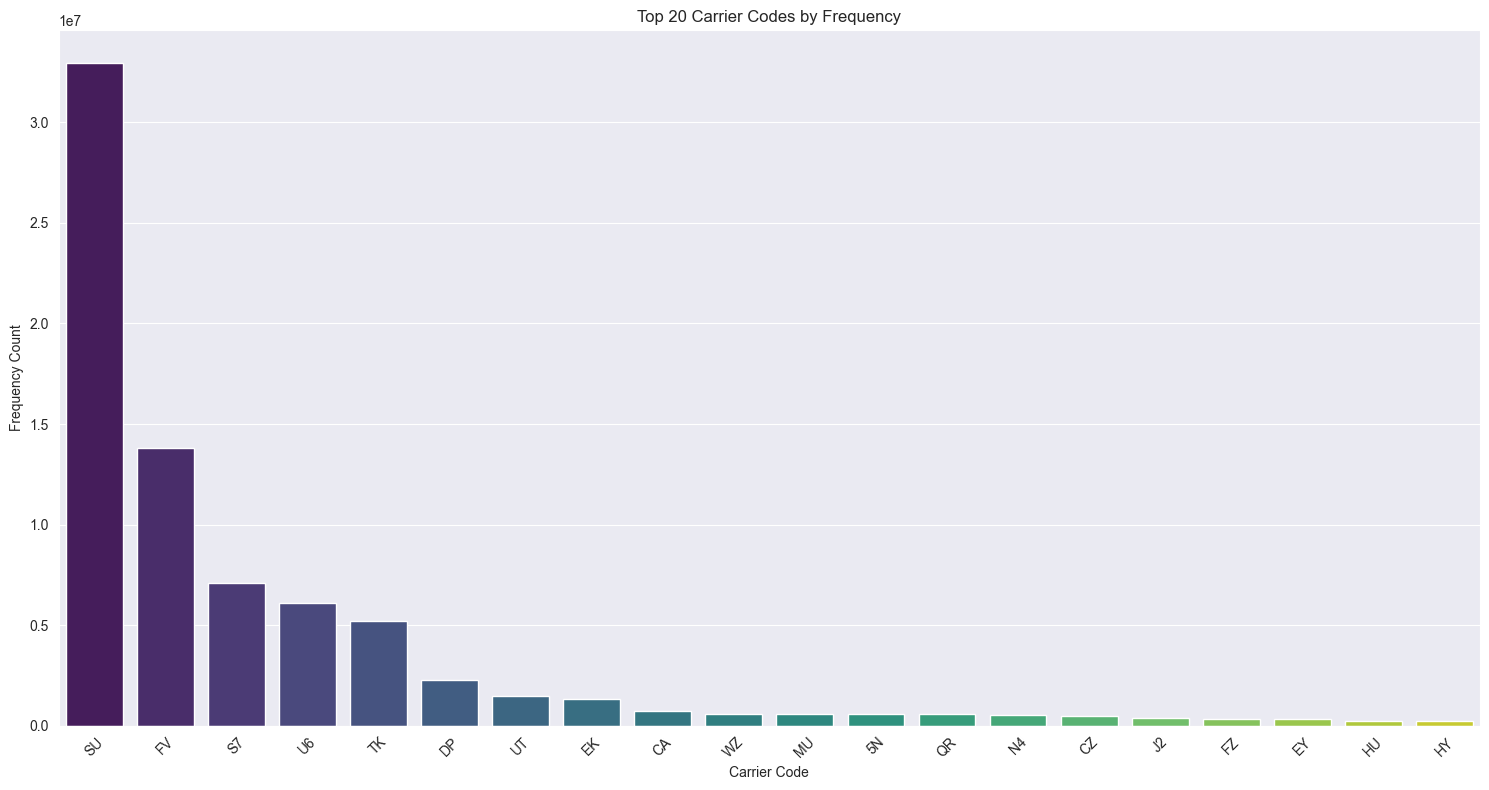

In [21]:
# Show the top 20 carrier codes
plt.figure(figsize=(15, 8))
top_carriers = carrier_code_counts.head(20)
sns.barplot(data=top_carriers, x="carrier_codes", y="count", palette="viridis", hue="carrier_codes")
plt.title("Top 20 Carrier Codes by Frequency")
plt.xlabel("Carrier Code")
plt.ylabel("Frequency Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [22]:
# Show frequent flyer codes
train_df['frequentFlyer'].unique()

frequentFlyer
str
"""SU/U6/S7/UT"""
"""SU/UT/DP"""
"""SU/SU"""
"""SU/QR"""
"""SU/S7/6R/UT/U6"""
…
"""S7/B2/SU"""
"""S7/DL/SU"""
"""SU/TK/EY/LH"""


In [23]:
# create a list of the unique frequent flyer codes
unique_ff_codes = (
    train_df.select("frequentFlyer")
    .filter(pl.col("frequentFlyer").is_not_null())  # Remove nulls
    .with_columns(
        pl.col("frequentFlyer").str.split("/").alias("ff_codes")  # Split by "/"
    )
    .select("ff_codes")
    .explode("ff_codes")  # Flatten the lists into individual rows
    .unique()  # Get unique codes
    .sort("ff_codes")  # Optional: sort them
    .to_series()
    .to_list()
)
print(unique_ff_codes)

# let's see if any do not have an associated carrier code
ff_not_in_carrier = set(unique_ff_codes) - set(unique_carrier_codes)
print("\nFF codes not in carrier list:", ff_not_in_carrier)


['- ЮТэйр ЗАО', '2G', '5N', '6R', '6W', '9X', 'A3', 'A4', 'AA', 'AB', 'AF', 'AI', 'AM', 'AT', 'AY', 'AZ', 'B2', 'BA', 'BD', 'C7', 'CA', 'CX', 'CZ', 'D2', 'D9', 'DL', 'DP', 'DV', 'EK', 'ET', 'EY', 'FV', 'FZ', 'GF', 'HU', 'HY', 'I8', 'J2', 'JP', 'JU', 'KC', 'KE', 'KL', 'LH', 'LO', 'LX', 'MS', 'MU', 'N4', 'OK', 'OS', 'OZ', 'PY', 'QR', 'R3', 'RT', 'S7', 'SK', 'SN', 'SQ', 'SU', 'SV', 'TK', 'U6', 'UA', 'UN', 'UT', 'VS', 'WY', 'Y7']

FF codes not in carrier list: {'D9', '6W', 'PY', '2G', 'AB', 'C7', 'BD', 'VS', 'JP', '- ЮТэйр ЗАО', '9X', 'UN'}


Frequent Flyer codes to Airlines:
* ЮТэйр ЗАО (translates to 'UTair JSC'):  UTair / UT
* AB: Air Berlin / AB
* D9: Daallo Airlines Somalia / D9
* 2G: Northwest Seaplanes / None
* UN: Transaero Airlines / UN (no longer in service)
* JP: Adria Airways / JP (no longer in service)
* 6W: Unknown
* VS: Virgin Atlantic Airways / VS
* BD: BMI British Midland / BD (integrated into British Airways)
* C7: Cinnamon Air / C7
* PY: Surinam Airways / PY
* 9X: Air Columbia / Unknown

So, translate 'ЮТэйр ЗАО' to UT and we'll keeps the others as they are.

Let's take a look at the airport codes.

In [24]:
iata_cols = [col for col in train_df.columns if "_iata" in col]

unique_iata_codes = (
    train_df
    .select([
        pl.concat_list([pl.col(col) for col in iata_cols])
        .list.explode()
        .drop_nulls()
        .unique()
        .alias('unique_iata_codes')
    ])
    .get_column('unique_iata_codes')
    .to_list()
)

print(f"Found {len(unique_iata_codes)} unique IATA codes")
print(unique_iata_codes)


Found 679 unique IATA codes
['EZV', 'SZX', 'RMO', '', 'YYZ', 'SKX', 'NYM', 'TGO', 'JJN', 'ZDN', 'PNR', 'IRT', 'UUA', 'FEG', 'WVB', 'KCK', 'NNM', 'AEP', 'JXA', 'ZYR', 'TAS', 'ECN', 'BUR', 'TOX', 'BPE', 'XIC', 'RAK', 'PEZ', 'CJB', 'LHR', 'IGU', 'XUZ', 'VCE', 'LOS', 'BDQ', 'LAD', 'AGP', 'ZVJ', 'ASB', 'LKO', 'BJS', 'KBR', 'DUB', 'VCP', 'TRV', 'BZX', 'SAW', 'MLE', 'BCN', 'UUS', 'HYN', 'REN', 'MIA', 'LYA', 'ZUH', 'LYG', 'FCO', 'AMS', 'KZN', 'BRE', 'JED', 'XIL', 'YJV', 'ADA', 'PKC', 'ASF', 'INC', 'HTA', 'LHW', 'VOG', 'GVA', 'IXB', 'OLZ', 'PTY', 'VNS', 'BQS', 'GZT', 'TSR', 'BRI', 'VKO', 'MSP', 'DYG', 'NCU', 'ATH', 'DLM', 'NUE', 'STR', 'VGA', 'BAK', 'YKS', 'YNJ', 'KPW', 'IAD', 'RIO', 'XSP', 'ODO', 'BHX', 'JNZ', 'BXU', 'AAE', 'GOI', 'HEL', 'LLV', 'BUD', 'BHZ', 'GOX', 'DDG', 'ZVR', 'ZIA', 'BLR', 'YBP', 'BTK', 'NGO', 'JGN', 'IJK', 'SZG', 'OSA', 'KQT', 'VVO', 'FUK', 'SVO', 'ARN', 'CGB', 'HLD', 'JGA', 'CTU', 'SEZ', 'DLU', 'EUN', 'SHJ', 'AER', 'HAM', 'SYX', 'XXQ', 'SCW', 'HMA', 'TYD', 'TLV', 'KGF', '

Finally, let's look at the baggage feature

In [34]:
baggage_df = train_df.select(["legs0_segments0_baggageAllowance_weightMeasurementType", "legs0_segments0_baggageAllowance_quantity"])
baggage_df_lazy = baggage_df.lazy()
baggage_df_filtered = baggage_df_lazy.filter(~(pl.col("legs0_segments0_baggageAllowance_weightMeasurementType").is_null()) & ~(pl.col("legs0_segments0_baggageAllowance_quantity").is_null())).collect()

In [27]:
baggage_df_filtered["legs0_segments0_baggageAllowance_weightMeasurementType"].unique()

legs0_segments0_baggageAllowance_weightMeasurementType
f64
0.0
1.0


In [28]:
baggage_df_filtered["legs0_segments0_baggageAllowance_quantity"].unique()

legs0_segments0_baggageAllowance_quantity
f64
0.0
1.0
2.0
3.0
10.0
…
40.0
45.0
46.0


In [29]:
filtered_data = baggage_df_filtered.filter(pl.col("legs0_segments0_baggageAllowance_weightMeasurementType") == 0)
filtered_data["legs0_segments0_baggageAllowance_quantity"].unique()

legs0_segments0_baggageAllowance_quantity
f64
0.0
1.0
2.0
3.0


In [30]:
filtered_data = baggage_df_filtered.filter(pl.col("legs0_segments0_baggageAllowance_weightMeasurementType") == 1)
filtered_data["legs0_segments0_baggageAllowance_quantity"].unique()

legs0_segments0_baggageAllowance_quantity
f64
0.0
10.0
15.0
20.0
23.0
…
40.0
45.0
46.0


Based on this, it looks like a MeasurementType = 0 indicates the Allowance_quantity is the number of bags limit, and when MeasurementType = 1, the Allowance_quanityt is a weight limit.

In [35]:
# Let's clean-up the data objects we generated for the EDA process
del baggage_df
del baggage_df_filtered
del baggage_df_lazy
del carrier_code_counts
del carrier_cols
del cust_searches
del ff_not_in_carrier
del filtered_data
del flight_counts
del iata_cols
del null_summary
del results
del top_carriers
del unique_carrier_codes
del unique_ff_codes
del unique_iata_codes
gc.collect()

21256

### Split Data into Training and Test Data Sets

In [36]:
train_df, test_df = stratified_flight_count_split(train_df)

Search size distribution:
  large: 5,035 searches
  medium: 13,896 searches
  small: 30,360 searches
  very_large: 3,141 searches
  very_small: 53,107 searches

Split results:
Train searches: 84,429
Test searches: 21,110
Train rows: 14,515,517
Test rows: 3,629,855

Train set distribution:
  large: 4,028 searches
  medium: 11,116 searches
  small: 24,288 searches
  very_large: 2,512 searches
  very_small: 42,485 searches

Test set distribution:
  large: 1,007 searches
  medium: 2,780 searches
  small: 6,072 searches
  very_large: 629 searches
  very_small: 10,622 searches


Since the data set is so large, we will need to manage memory throughout the process. To assist with this, I am saving the training and test splits as parquet files that we can reload as needed without having to regenerate new splits.

In [37]:
# Save the train/test splits
train_df.write_parquet('data/train_df.parquet')
test_df.write_parquet('data/test_df.parquet')

# Remove test data from memory
del test_df
gc.collect()

0

In [38]:
# Here we can check if train_df exists and load if we restarted the process at this point.
try:
    train_df.head()
except NameError:
    train_df = pl.read_parquet('data/train_df.parquet')
    print(f'loaded train_df: {train_df.shape}')

train_df.head(100)

Id,bySelf,companyID,corporateTariffCode,frequentFlyer,nationality,isAccess3D,isVip,legs0_arrivalAt,legs0_departureAt,legs0_duration,legs0_segments0_aircraft_code,legs0_segments0_arrivalTo_airport_city_iata,legs0_segments0_arrivalTo_airport_iata,legs0_segments0_baggageAllowance_quantity,legs0_segments0_baggageAllowance_weightMeasurementType,legs0_segments0_cabinClass,legs0_segments0_departureFrom_airport_iata,legs0_segments0_duration,legs0_segments0_flightNumber,legs0_segments0_marketingCarrier_code,legs0_segments0_operatingCarrier_code,legs0_segments0_seatsAvailable,legs0_segments1_aircraft_code,legs0_segments1_arrivalTo_airport_city_iata,legs0_segments1_arrivalTo_airport_iata,legs0_segments1_baggageAllowance_quantity,legs0_segments1_baggageAllowance_weightMeasurementType,legs0_segments1_cabinClass,legs0_segments1_departureFrom_airport_iata,legs0_segments1_duration,legs0_segments1_flightNumber,legs0_segments1_marketingCarrier_code,legs0_segments1_operatingCarrier_code,legs0_segments1_seatsAvailable,legs0_segments2_aircraft_code,legs0_segments2_arrivalTo_airport_city_iata,…,legs1_segments2_baggageAllowance_weightMeasurementType,legs1_segments2_cabinClass,legs1_segments2_departureFrom_airport_iata,legs1_segments2_duration,legs1_segments2_flightNumber,legs1_segments2_marketingCarrier_code,legs1_segments2_operatingCarrier_code,legs1_segments2_seatsAvailable,legs1_segments3_aircraft_code,legs1_segments3_arrivalTo_airport_city_iata,legs1_segments3_arrivalTo_airport_iata,legs1_segments3_baggageAllowance_quantity,legs1_segments3_baggageAllowance_weightMeasurementType,legs1_segments3_cabinClass,legs1_segments3_departureFrom_airport_iata,legs1_segments3_duration,legs1_segments3_flightNumber,legs1_segments3_marketingCarrier_code,legs1_segments3_operatingCarrier_code,legs1_segments3_seatsAvailable,miniRules0_monetaryAmount,miniRules0_percentage,miniRules0_statusInfos,miniRules1_monetaryAmount,miniRules1_percentage,miniRules1_statusInfos,pricingInfo_isAccessTP,pricingInfo_passengerCount,profileId,ranker_id,requestDate,searchRoute,sex,taxes,totalPrice,selected,__index_level_0__
i64,bool,i64,i64,str,i64,bool,bool,str,str,str,str,str,str,f64,f64,f64,str,str,str,str,str,f64,str,str,str,f64,f64,f64,str,str,str,str,str,f64,str,str,…,f64,f64,str,str,str,str,str,f64,str,str,str,f64,f64,f64,str,str,str,str,str,f64,f64,f64,f64,f64,f64,f64,f64,i64,i64,str,datetime[ns],str,bool,f64,f64,i64,i64
0,true,57323,null,"""S7/SU/UT""",36,false,false,"""2024-06-15T16:20:00""","""2024-06-15T15:40:00""","""02:40:00""","""YK2""","""KJA""","""KJA""",1.0,0.0,1.0,"""TLK""","""02:40:00""","""216""","""KV""","""KV""",9.0,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,1.0,1,2087645,"""98ce0dabf6964640b63079fbafd42c…",2024-05-17 03:03:08,"""TLKKJA/KJATLK""",true,370.0,16884.0,1,0
1,true,57323,123,"""S7/SU/UT""",36,true,false,"""2024-06-15T14:50:00""","""2024-06-15T09:25:00""","""07:25:00""","""E70""","""OVB""","""OVB""",1.0,0.0,1.0,"""TLK""","""02:50:00""","""5358""","""S7""","""S7""",4.0,"""E70""","""KJA""","""KJA""",1.0,0.0,1.0,"""OVB""","""01:20:00""","""5311""","""S7""","""S7""",4.0,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,2300.0,null,1.0,3500.0,null,1.0,1.0,1,2087645,"""98ce0dabf6964640b63079fbafd42c…",2024-05-17 03:03:08,"""TLKKJA/KJATLK""",true,2240.0,51125.0,0,1
2,true,57323,null,"""S7/SU/UT""",36,false,false,"""2024-06-15T14:50:00""","""2024-06-15T09:25:00""","""07:25:00""","""E70""","""OVB""","""OVB""",1.0,0.0,1.0,"""TLK""","""02:50:00""","""5358""","""S7""","""S7""",4.0,"""E70""","""KJA""","""KJA""",1.0,0.0,1.0,"""OVB""","""01:20:00""","""5311""","""S7""","""S7""",4.0,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,2300.0,null,1.0,3500.0,null,1.0,1.0,1,2087645,"""98ce0dabf696

### Traveler Segmentation

This section will perform the traveler segmentation. The goal is to generate the groups of similar travelers based on their profile attributes and search history. We will engineer additional features to try and provide additional behavioral insights.

#### Feature Engineering

The first step for the traveler segmentation is feature en

In [63]:
# Import libraries and functions needed for Travel Clustering
from sklearn.cluster import DBSCAN, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import RobustScaler

# Import project functions
from src.cluster_cust_data import (
    encode_features, remove_outliers, alternative_clustering_methods, gen_optimum_num_clusters,
    analyze_clusters, predict_cluster_with_centroids
)
from src.cust_feature_eng import extract_customer_features
from src.flt_feature_eng import extract_flight_features, prepare_combined_data
from src.ranking import train_segment_based_ranker
from src.ranking_eval import  test_lgb_ranker, test_segment_based_ranker


In [40]:
# 1. Feature Engineering
cust_data = extract_customer_features(train_df)
print(f'Generated {len(cust_data.columns)} customer features for {len(cust_data)} customers')

Generated 58 customer features for 30152 customers


In [41]:
# 2. Remove outliers
cust_data_cleaned, outlier_indices = remove_outliers(cust_data, contamination=0.05)

Removed 1,508 outliers (5.0%)


In [42]:
# 3. Feature encoding
cust_data_encoded, encoders = encode_features(cust_data_cleaned)

In [43]:
# 4. Feature scaling
scaler = RobustScaler()
scaled_features = scaler.fit_transform(cust_data_encoded.to_pandas())

In [44]:
# 5. Dimensionality reduction
n_components = 0.95  # retain components that explain 95% of variance
# n_components = 30    # retain 30 components

reducer = PCA(n_components=n_components, random_state=42)
reduced_features = reducer.fit_transform(scaled_features)

if hasattr(reducer, 'explained_variance_ratio_'):
    total_variance = reducer.explained_variance_ratio_.sum()
    print(f"PCA retained {total_variance:.3f} of total variance with {reduced_features.shape[1]} components")

PCA retained 0.957 of total variance with 10 components


Let's save the processed customer features, so that we can return to this point if needed.

Now we will test clustering using Gaussian Mixture Model, DBScan, and Agglomerative Clustering methods

In [58]:
# 6. Try alternative clustering methods
clustering_results = alternative_clustering_methods(reduced_features)

Testing Gaussian Mixture Models...
Testing DBSCAN...
eps: 0.70 | Clusters: 6 | Noise: 78.29% | Silhouette: 0.7726
eps: 1.00 | Clusters: 8 | Noise: 57.63% | Silhouette: 0.4292
eps: 1.50 | Clusters: 7 | Noise: 39.58% | Silhouette: 0.5649
Testing Agglomerative Clustering...


... and compare the results

In [59]:
# Iterate through each method's results
for method, results in clustering_results.items():
    print(f"{method.upper():15s} | Silhouette: {results['silhouette']:.4f} | Clusters: {results['n_clusters']:2d}")

GMM             | Silhouette: 0.3495 | Clusters: 15
DBSCAN          | Silhouette: -0.2920 | Clusters:  6
AGGLOMERATIVE   | Silhouette: 0.6589 | Clusters: 15


DBSCAN didn't fare well, as the Noise ratio for all configurations that generated reasonable clusters is excessively high. Out of the three methods, Agglomerative Clustering performed the best. As such, we will optimize the hyperparameter configuration and go with that model for our unsupervised learning method.

In [62]:
# 7. Perform hyperparameter optimization
clustering_results = gen_optimum_num_clusters(reduced_features)

# 7. Clustering results
print("\n🏆 CLUSTERING RESULTS:")
print(f"  Clusters: {clustering_results['n_clusters']:2d}| Silhouette: {clustering_results['silhouette']:.4f} | ")

Best number of clusters: 2, with Silhouette score: 0.9771

🏆 CLUSTERING RESULTS:
  Clusters:  2| Silhouette: 0.9460 | 


In [64]:
# Analyze the cluster results
analyze_clusters(cust_data_cleaned, clustering_results['labels'])


📊 CLUSTER PROFILES:
shape: (2, 7)
┌─────────┬──────────────┬──────────┬────────────────┬───────────────┬──────────────┬───────┐
│ cluster ┆ avg_searches ┆ vip_rate ┆ roundtrip_rate ┆ avg_lead_days ┆ avg_carriers ┆ size  │
│ ---     ┆ ---          ┆ ---      ┆ ---            ┆ ---           ┆ ---          ┆ ---   │
│ i64     ┆ f64          ┆ f64      ┆ f64            ┆ f64           ┆ f64          ┆ u32   │
╞═════════╪══════════════╪══════════╪════════════════╪═══════════════╪══════════════╪═══════╡
│ 0       ┆ 448.158268   ┆ 0.004301 ┆ 0.5611         ┆ 15.076692     ┆ 5.134699     ┆ 28597 │
│ 1       ┆ 584.638298   ┆ 1.0      ┆ 0.699307       ┆ 13.297656     ┆ 6.531915     ┆ 47    │
└─────────┴──────────────┴──────────┴────────────────┴───────────────┴──────────────┴───────┘


In [65]:
# Add cluster labels to the customer data set
cust_data_cleaned = cust_data_cleaned.with_columns(pl.Series('customer_segment', clustering_results['labels']))

In [66]:
cust_data_cleaned.group_by('customer_segment').len()

customer_segment,len
i64,u32
1,47
0,28597


In [67]:
# Save customer features
cust_data_cleaned.write_parquet('data/train_customer_features.parquet')

In [68]:
# Save the best Agglomerative model
joblib.dump(clustering_results, 'data/agglomerative_model.joblib')

# Save the data encoders/scaler/reducer
joblib.dump({
    'encoders': encoders,
    'scaler': scaler,
    'reducer': reducer
}, 'data/data_encoders_scaler_reducer.joblib')

['data/data_encoders_scaler_reducer.joblib']

In [69]:
# Remove unneeded objects to free memory
del GaussianMixture
del PCA
del clustering_results
del cust_data
del cust_data_encoded
del encoders
del reduced_features
del reducer
del results
del scaled_features
del scaler
gc.collect()

490

### Flight Ranking

#### Feature Engineering

In [70]:
# Load training data if not already loaded
try:
    train_df.head()
except NameError:
    train_df = pl.read_parquet('data/train_df.parquet')

In [ ]:
train_df = extract_flight_features(train_df)

In [ ]:
train_df.head(100)

In [ ]:
# Save flight features for train data
train_df.write_parquet('data/train_flight_features.parquet')

#### Prepare Training Data

In [ ]:
# Prepare training data by combining customer features with flight features
train_df = prepare_combined_data(train_df, pl.scan_parquet('data/train_customer_features.parquet'))  # loading cust_features lazy

In [ ]:
train_df.head(100)

In [ ]:
train_df.shape

In [ ]:
train_df.write_parquet('data/train_combined_features.parquet')

In [ ]:
train_df.group_by('customer_segment').len().select(['customer_segment', 'len']).rows()

In [ ]:
segment_stats = (
    train_df
    .group_by(['customer_segment', 'ranker_id'])
    .agg([
        pl.first('total_searches').alias('customer_total_searches'),
        pl.len().alias('flights_per_search')
    ])
    .group_by('customer_segment')
    .agg([
        pl.len().alias('total_searches'),                    # Count of search sessions
        pl.col('customer_total_searches').n_unique().alias('num_customers'),  # Since each unique total_searches value represents a customer
        pl.col('flights_per_search').min().alias('min_flights_per_search'),
        pl.col('flights_per_search').max().alias('max_flights_per_search'),
        pl.col('flights_per_search').mean().alias('avg_flights_per_search')
    ])
    .sort('customer_segment')
)
segment_stats

In [ ]:
try:
    train_df.head()
except NameError:
    train_df = pl.read_parquet('data/train_combined_features.parquet')
    print(f'loaded combined features from parquet file: {train_df.shape}')

In [ ]:
ranker_models = train_segment_based_ranker(train_df)

In [ ]:
joblib.dump(ranker_models, 'data/segment_ranker_models.joblib')
ranker_models

In [ ]:
# Remove the feature dataframe to free up memory
del train_df
gc.collect()

### Test Ranking

In [ ]:
# Get Test data set
test_df = pl.read_parquet('data/test_df.parquet')
test_df.head()

In [ ]:
# Customer Feature Engineering
cust_data = extract_customer_features(test_df)
print(f'Generated {len(cust_data.columns)} customer features for {len(cust_data)} customers')

In [ ]:
# Get the encoders, scaler, and reducer from the joblib file for the Train data clustering process
data_encoders_scaler_reducer = joblib.load('data/data_encoders_scaler_reducer.joblib')
print('loaded encoders, sclaer, reducer from joblib file')

encoders = data_encoders_scaler_reducer['encoders']
scaler = data_encoders_scaler_reducer['scaler']
reducer = data_encoders_scaler_reducer['reducer']

In [ ]:
# Encode customer features
cust_data_encoded, _ = encode_features(cust_data, encoders)

In [ ]:
# Scale customer features
scaled_features = scaler.transform(cust_data_encoded.to_pandas())

In [ ]:
# Dimensionality reduction
reduced_features = reducer.transform(scaled_features)

In [ ]:
# Load Agglomeratvie clustering results from Train to get model centroids
clustering_results = joblib.load('data/agglomerative_model.joblib')
print(f'Loaded Agglomerative Clustering results from joblib file for {clustering_results['n_clusters']} clusters')

In [ ]:
# Generate cluster label predictions for Test data
cluster_segments = predict_cluster_with_centroids(reduced_features, clustering_results['centroids'])

In [ ]:
# Add predicted cluster labels to the customer data
cust_data = cust_data.with_columns(pl.Series('customer_segment', cluster_segments[0]))
cust_data.head(1000)

In [ ]:
# Extract Flight Features
test_df = extract_flight_features(test_df)

In [ ]:
# Combine customer and flight features data
test_df = prepare_combined_data(test_df, cust_data)
test_df.head(100)

In [ ]:
# Get models if not already loaded
try:
    ranker_models
except NameError:
    ranker_models = joblib.load('data/segment_ranker_models.joblib')

In [ ]:
results, test_df = test_segment_based_ranker(ranker_models, test_df)

In [ ]:
test_df.head(100)

In [ ]:
# Evaluate overall hit rate for segmented prediction
from src.ranking_eval import calculate_hit_rate_at_k

y_true = test_df['selected'].to_numpy()
y_pred = test_df['y_pred'].to_numpy()
group_sizes = (
        test_df
        .group_by('ranker_id', maintain_order=True)
        .len()
        .select('len')
        .to_numpy()
        .flatten()
    )
ranker_ids = test_df['ranker_id'].unique().sort()
hitrate, details = calculate_hit_rate_at_k(y_true, y_pred, group_sizes, ranker_ids, k=3)

In [ ]:
hitrate

In [ ]:
# Test if full model is better for predicting on segments with low results scores
_ = test_lgb_ranker(ranker_models[99], test_df.filter(pl.col('customer_segment') == 7).drop('y_pred'))

In [ ]:
test_df = test_df.drop('y_pred')

In [ ]:
# Except for segment 7, all other segments performed better under the full training model
test_results = test_lgb_ranker(ranker_models[99], test_df, k=3, min_size=10)

In [ ]:
# Let's compare segmented prediction vs. general model hit rates, not counting groups smaller than 10 flights
for i in range(len(ranker_models) - 1):
    print(f'Results for segment {i} using segment model:')
    _ = test_lgb_ranker(ranker_models[i], test_df.filter(pl.col('customer_segment') == i), k=3, min_size=10)
    print(f'Results for segment {i} using general model:')
    _ = test_lgb_ranker(ranker_models[99], test_df.filter(pl.col('customer_segment') == i), k=3, min_size=10)

## Acknowledgements

 - [FlightRank 2025: Aeroclub RecSys Cup](https://www.kaggle.com/competitions/aeroclub-recsys-2025)
 - [IEEE-CIS Fraud Detection Data Description](https://www.kaggle.com/c/ieee-fraud-detection/discussion/101203)
 - [Vesta Corporation](https://www.vesta.io/)
    -  provided the competition project dataset files
 - [NT Project Summary: Part 3](https://www.kaggle.com/code/mariajunior/nt-project-summary-part-3/notebook)
    -  provided some starting parameters for evaluating LightGBM
 - [readme.so Editor](https://readme.so/editor)
    -  a handy online README.md editor by [Katherine Oelsner](https://www.katherineoelsner.com/)